In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
from matplotlib import pyplot as plt

In [40]:
# verificação se há gpu disponível
print("GPU: ", len(tf.config.list_physical_devices('GPU')))
# É necessário usar a GPU, caso contrário, o treinamento vai demorar bastante

GPU:  1


In [41]:
tf.random.set_seed(1) # tensorflow

In [42]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() # Carregamento da base de dados
dataset = np.concatenate([x_train, x_test], axis=0) # junta os dados do treino e do teste
dataset = np.expand_dims(dataset, -1).astype("float32") / 255 # normalizacao

In [43]:
BATCH_SIZE = 64
# camadas convolucionais trabalham com três canais
dataset = np.reshape(dataset, (-1, 28, 28, 1))
# criando um objeto
dataset = tf.data.Dataset.from_tensor_slices(dataset)
# setando o batch size pra que nao leia uma imagem por vez
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [44]:
# Criação do modelo
generator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(150,)),
  layers.Dense(7*7*256),
  layers.Reshape(target_shape=(7, 7, 256)),
  layers.Conv2DTranspose(256, 3, activation=keras.layers.LeakyReLU(), strides=2, padding="same"),
  layers.Conv2DTranspose(128, 3, activation=keras.layers.LeakyReLU(), strides=2, padding="same"),
  layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
])

generator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 12544)               │       1,894,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 28, 28, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 28, 28, 1)           │           1,153 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,780,417 (10.61 MB)

 Trainable params: 2,780,417 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# geração do discrimador
discriminator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),
  layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),
  layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
  layers.Flatten(),
  layers.Dense(64, activation="relu"),
  layers.Dropout(0.2),
  layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 256)         │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 699,137 (2.67 MB)

 Trainable params: 699,137 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Definição da taxa de apredizado, tem que manter taxas diferentes para haver uma competição balanceada
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)

# classificador binário
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

# métrica pra acurácia
gAccMetric = tf.keras.metrics.BinaryAccuracy()
dAccMetric = tf.keras.metrics.BinaryAccuracy()

In [47]:
@tf.function
def trainDStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, 150))
  # concatenação dos titulos fakes e dos reais
  y_true = tf.concat([tf.ones(batchSize, 1),tf.zeros(batchSize, 1)],axis=0)
  # gravação dos gradientes
  with tf.GradientTape() as tape:
    fake = generator(noise)
    # concatena os dados fakes e reais
    x = tf.concat([data, fake], axis=0)
    # confere se o discriminador é capaz
    y_pred = discriminator(x)
    # calculo da loss
    discriminatorLoss = lossFn(y_true, y_pred)
  # atualiza os pesos
  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))
  # reporta acurácia
  dAccMetric.update_state(y_true, y_pred)
  # retorna a loss para visualizaçõa
  return {"discriminator_loss": discriminatorLoss,"discriminator_accuracy": dAccMetric.result()}

In [48]:
@tf.function
def trainGStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, 150))
  # saída é classificada como verdadeira
  y_true = tf.ones(batchSize, 1)

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise)) # confere se o discriminador é capaz
    generatorLoss = lossFn(y_true, y_pred) # calculo da loss
  # atualiza os pesos
  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))
  # reporta acurácia
  gAccMetric.update_state(y_true, y_pred)
  # retorna a loss para visualizaçõa
  return {"generator_loss": generatorLoss,"generator_accuracy": gAccMetric.result()}

In [51]:
# mostrando as imagens
def plotImages(model):
    images = model(np.random.normal(size=(81, 150)))
    plt.figure(figsize=(9, 9))
    for i, image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
        plt.axis('off')

    plt.show();

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


E:0, Loss G:2.7497, Loss D:0.1232, Acc G:%0.20, Acc D:%98.35


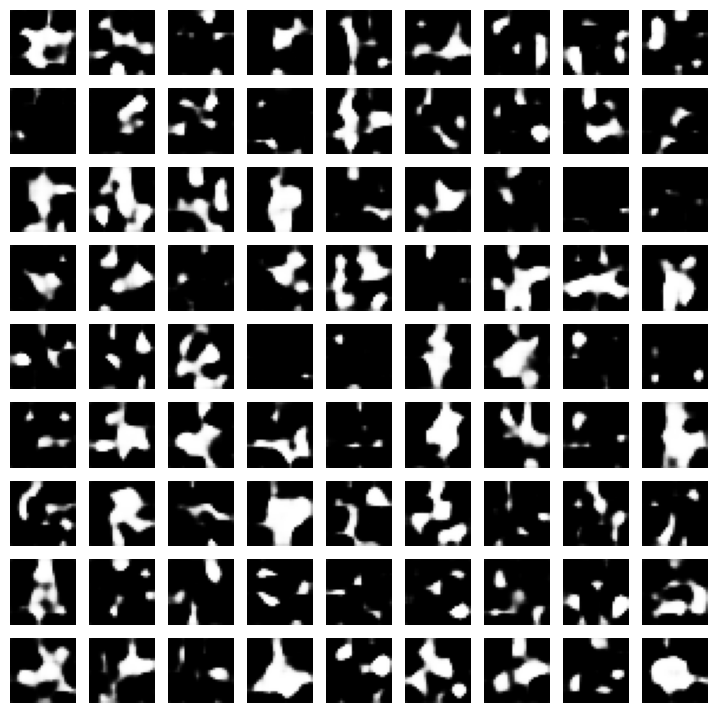

E:1, Loss G:3.1929, Loss D:0.1025, Acc G:%0.45, Acc D:%98.35
E:2, Loss G:2.8886, Loss D:0.1457, Acc G:%0.86, Acc D:%97.62


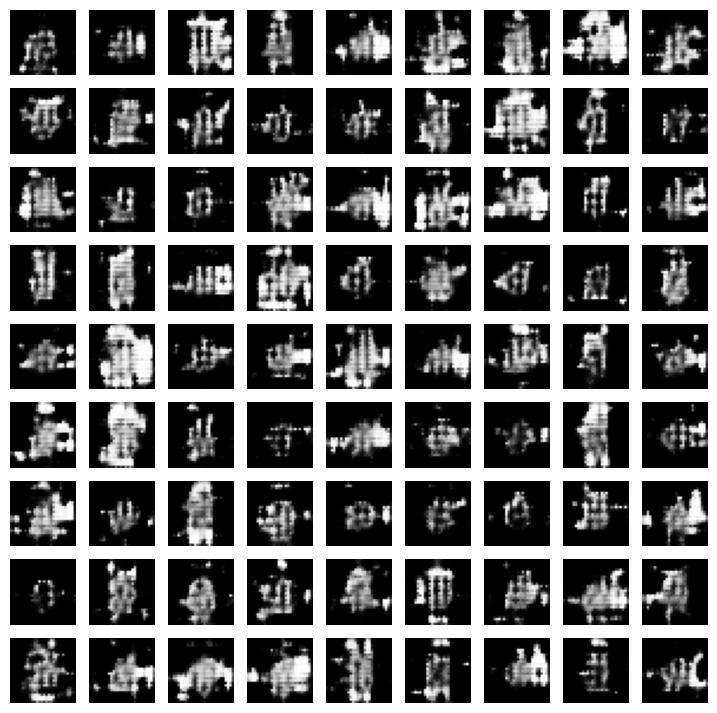

E:3, Loss G:2.3516, Loss D:0.2162, Acc G:%1.40, Acc D:%96.61
E:4, Loss G:1.8878, Loss D:0.3331, Acc G:%2.28, Acc D:%95.18


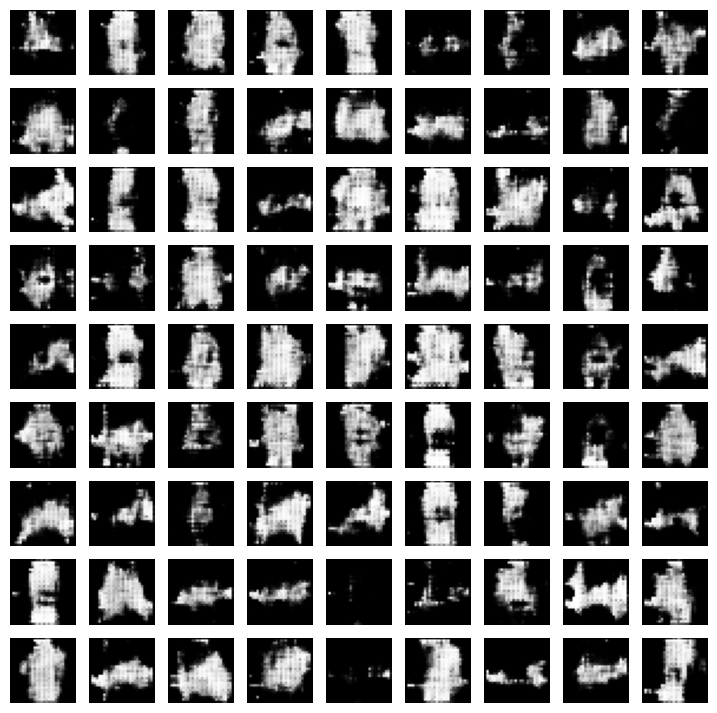

E:5, Loss G:1.8642, Loss D:0.3083, Acc G:%3.35, Acc D:%93.76
E:6, Loss G:1.8102, Loss D:0.3230, Acc G:%3.95, Acc D:%93.01


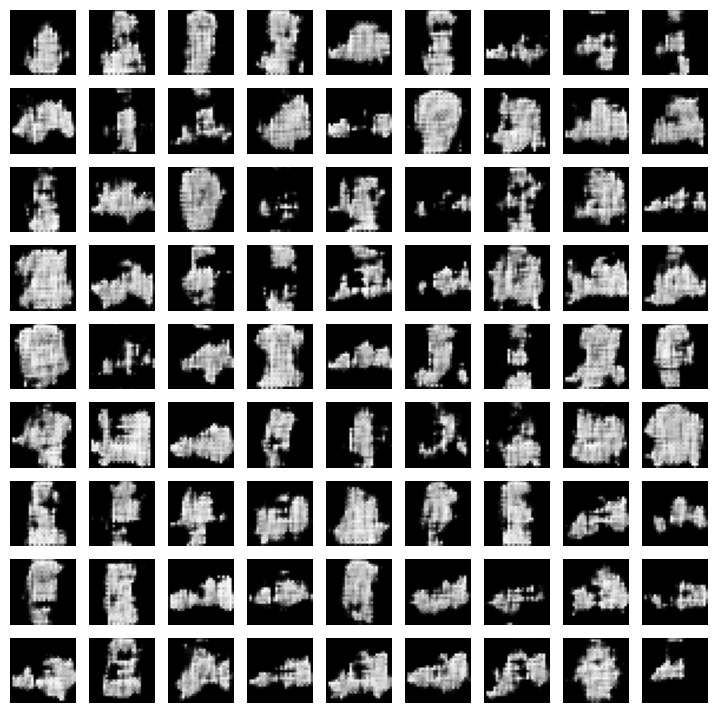

E:7, Loss G:1.7240, Loss D:0.3414, Acc G:%4.47, Acc D:%92.30
E:8, Loss G:1.6876, Loss D:0.3541, Acc G:%4.99, Acc D:%91.59


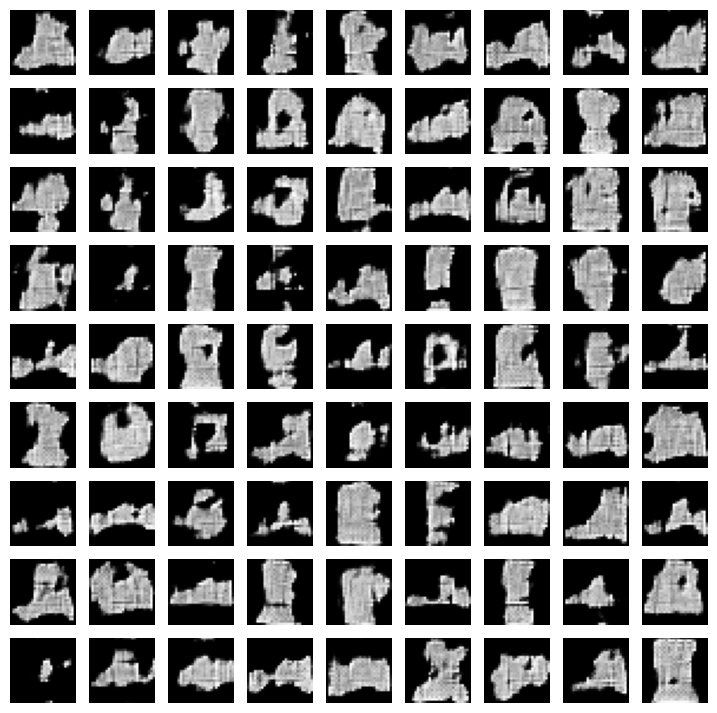

E:9, Loss G:1.7449, Loss D:0.3255, Acc G:%5.42, Acc D:%91.07
E:10, Loss G:1.7652, Loss D:0.3128, Acc G:%5.62, Acc D:%90.78


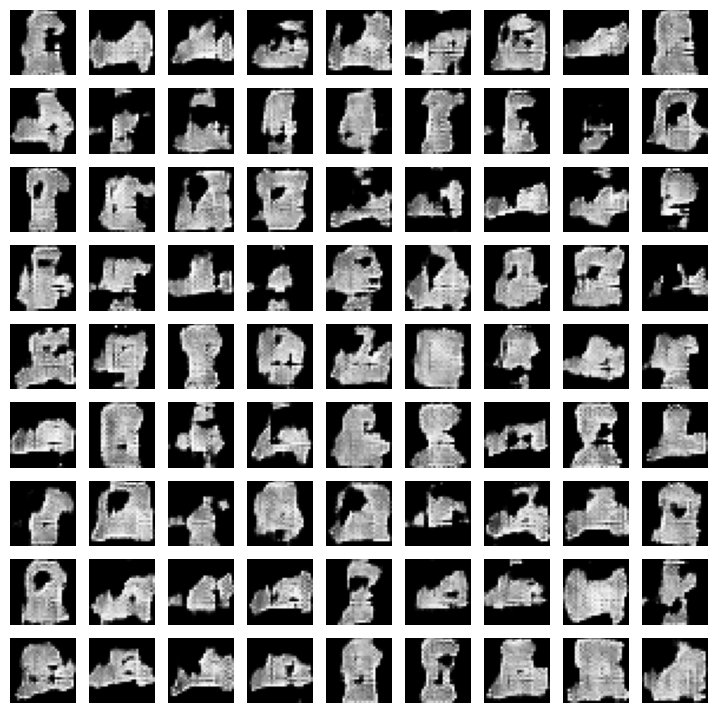

E:11, Loss G:1.8480, Loss D:0.2967, Acc G:%5.72, Acc D:%90.61
E:12, Loss G:1.9351, Loss D:0.2971, Acc G:%5.77, Acc D:%90.51


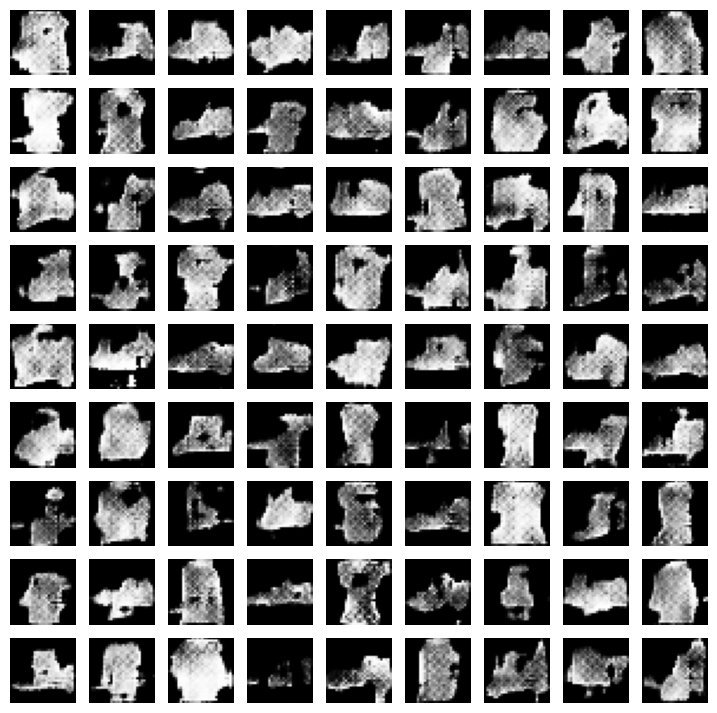

E:13, Loss G:1.9734, Loss D:0.2993, Acc G:%5.87, Acc D:%90.36
E:14, Loss G:2.0898, Loss D:0.2932, Acc G:%6.01, Acc D:%90.22


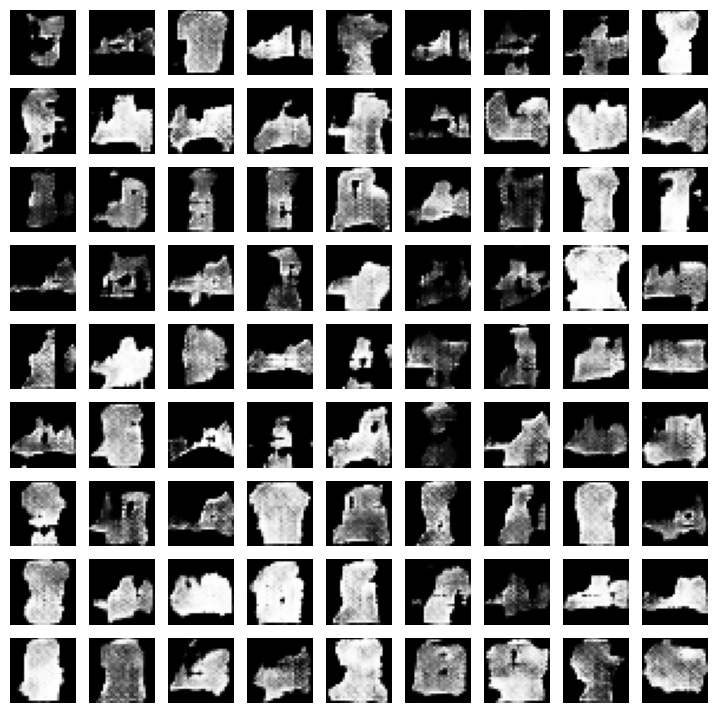

E:15, Loss G:2.0365, Loss D:0.2943, Acc G:%6.12, Acc D:%90.10
E:16, Loss G:2.1816, Loss D:0.2843, Acc G:%6.20, Acc D:%90.05


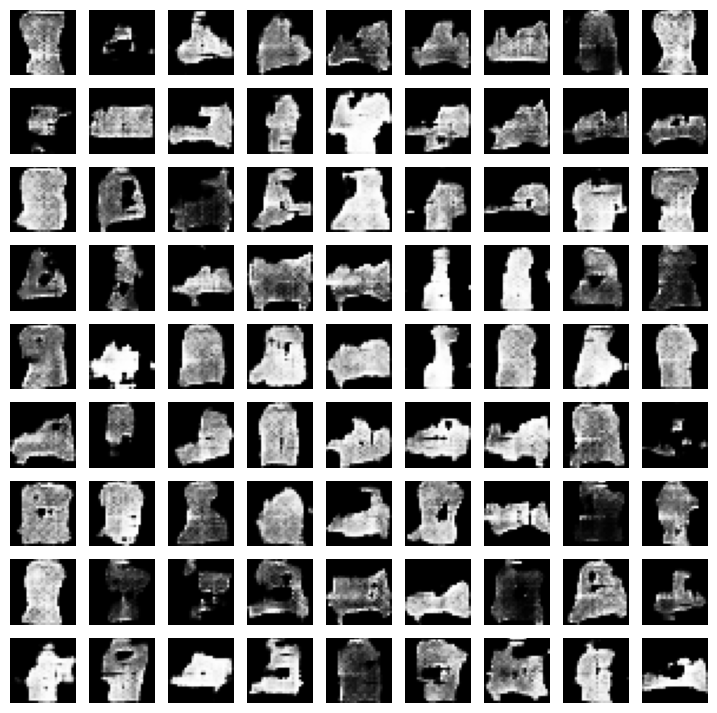

E:17, Loss G:2.2182, Loss D:0.2626, Acc G:%6.26, Acc D:%90.00
E:18, Loss G:2.1987, Loss D:0.2585, Acc G:%6.27, Acc D:%90.00


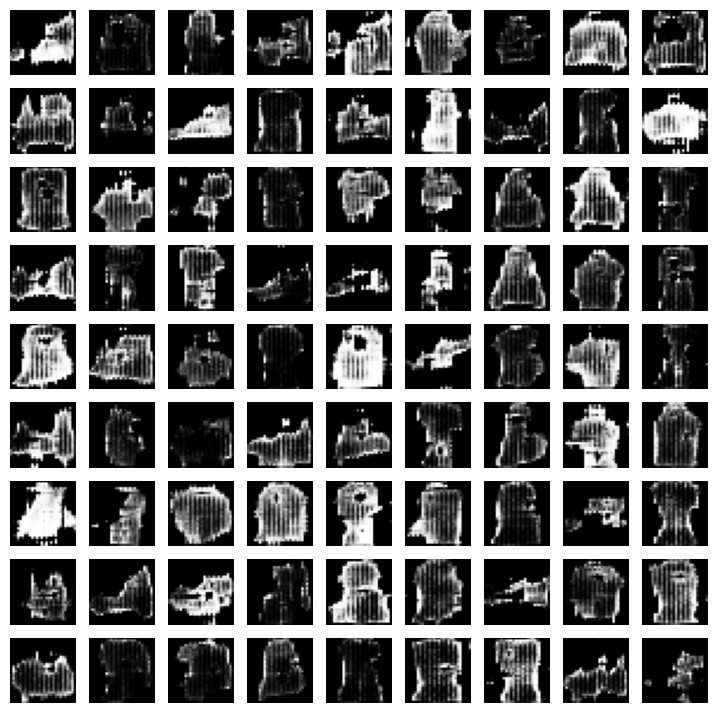

E:19, Loss G:2.1769, Loss D:0.2700, Acc G:%6.25, Acc D:%90.03
E:20, Loss G:2.2735, Loss D:0.2573, Acc G:%6.25, Acc D:%90.04


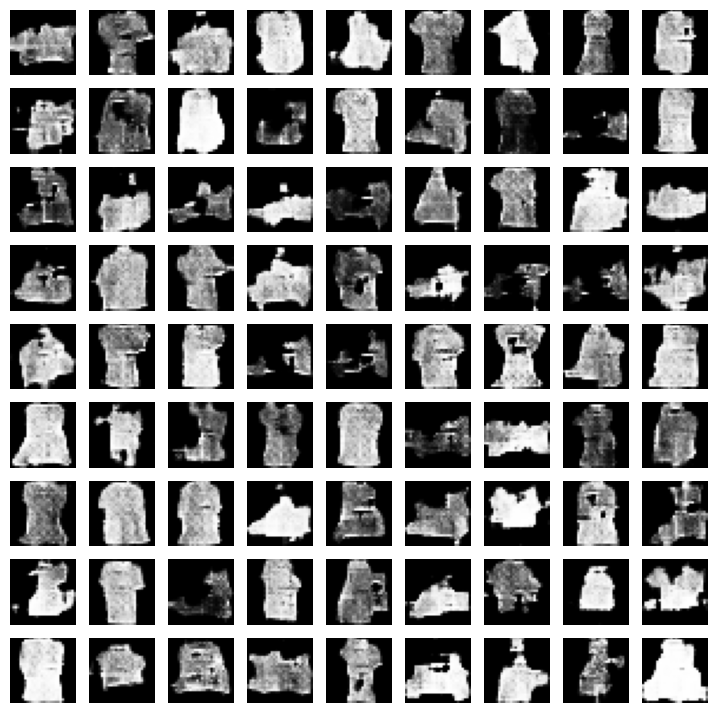

E:21, Loss G:2.6437, Loss D:0.2045, Acc G:%6.20, Acc D:%90.09
E:22, Loss G:2.2171, Loss D:0.2532, Acc G:%6.14, Acc D:%90.17


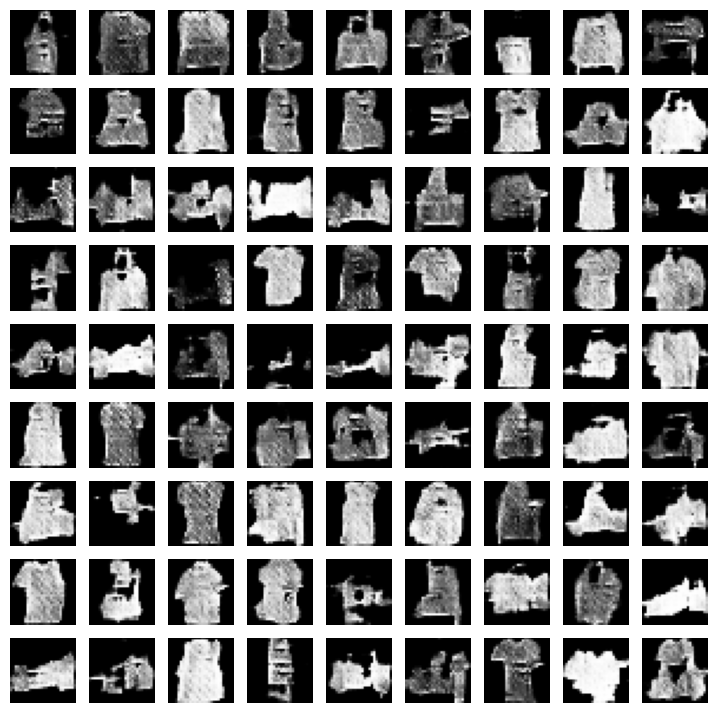

E:23, Loss G:2.3143, Loss D:0.2436, Acc G:%6.10, Acc D:%90.21
E:24, Loss G:2.9897, Loss D:0.1723, Acc G:%6.03, Acc D:%90.29


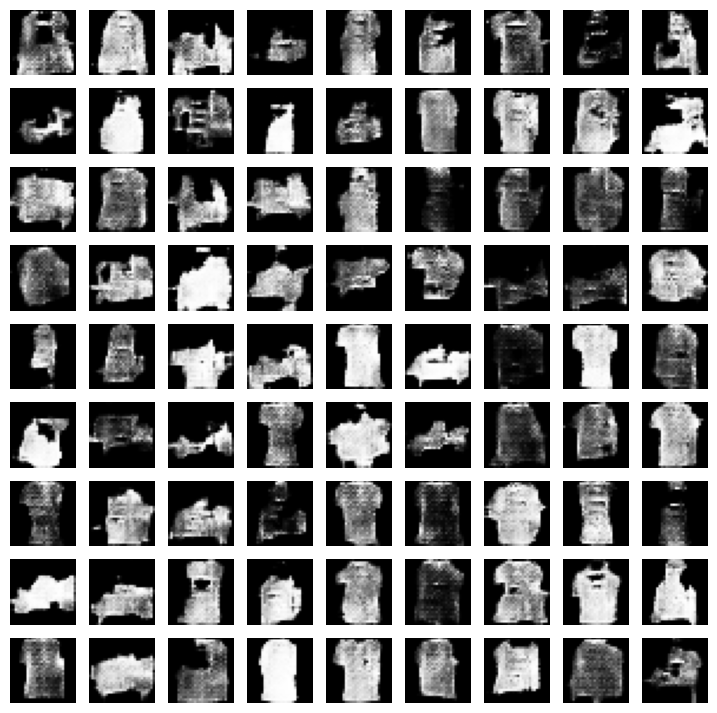

E:25, Loss G:2.2759, Loss D:0.2645, Acc G:%5.98, Acc D:%90.36
E:26, Loss G:2.2383, Loss D:0.2468, Acc G:%5.97, Acc D:%90.37


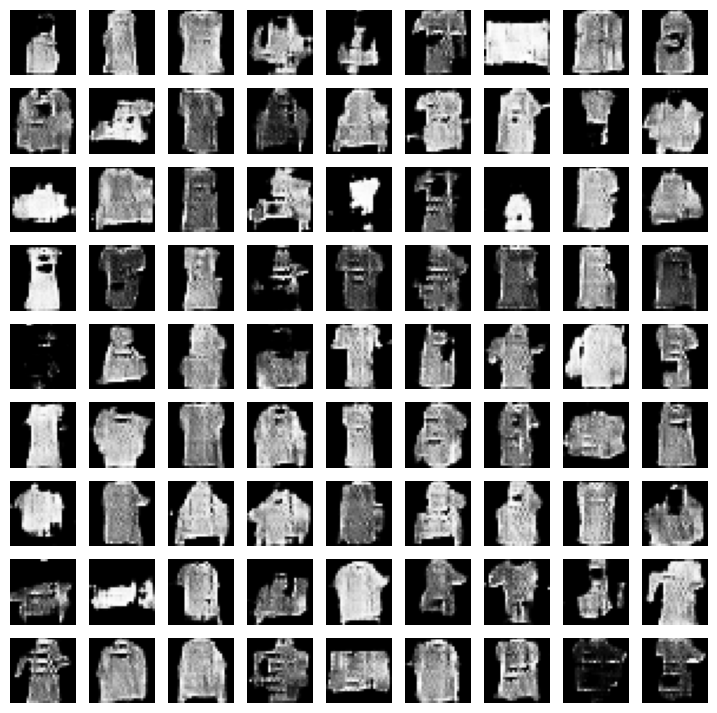

E:27, Loss G:2.1690, Loss D:0.2590, Acc G:%5.94, Acc D:%90.37
E:28, Loss G:2.1274, Loss D:0.2712, Acc G:%5.92, Acc D:%90.36


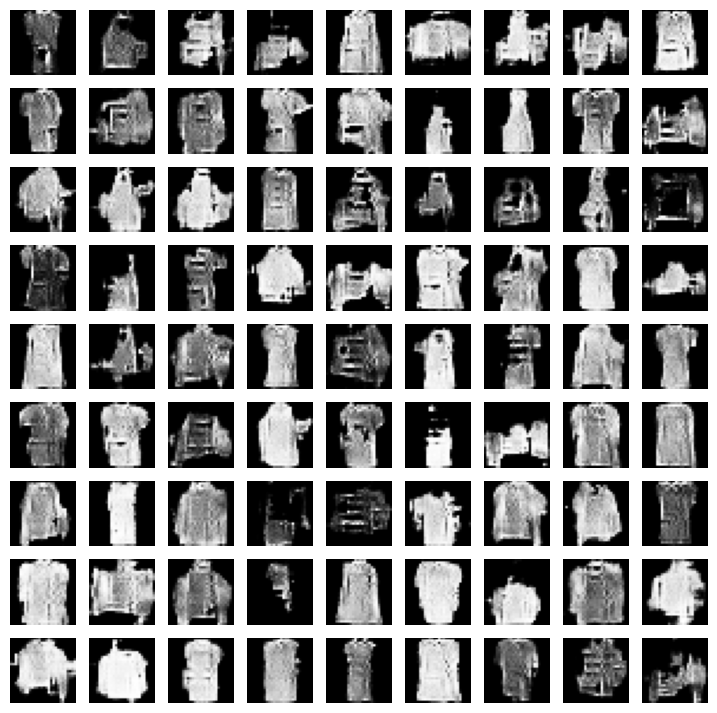

E:29, Loss G:2.0990, Loss D:0.2812, Acc G:%5.91, Acc D:%90.33


In [52]:
# Treinamento com 30 epocas
for epoch in range(30):

  # variaveis para amazenamento dos dados do treinamento
  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  cnt = 0
  for batch in dataset:
    # treina o discriminador
    dLoss = trainDStep(batch)
    dLossSum += dLoss['discriminator_loss']
    dAccSum += dLoss['discriminator_accuracy']
    # treina o gerador
    gLoss = trainGStep(batch)
    gLossSum += gLoss['generator_loss']
    gAccSum += gLoss['generator_accuracy']
    cnt += 1

  # printa o resultado
  print("E:{}, Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
      epoch,
      gLossSum/cnt,
      dLossSum/cnt,
      100 * gAccSum/cnt,
      100 * dAccSum/cnt
  ))

  if epoch % 2 == 0:
    plotImages(generator)

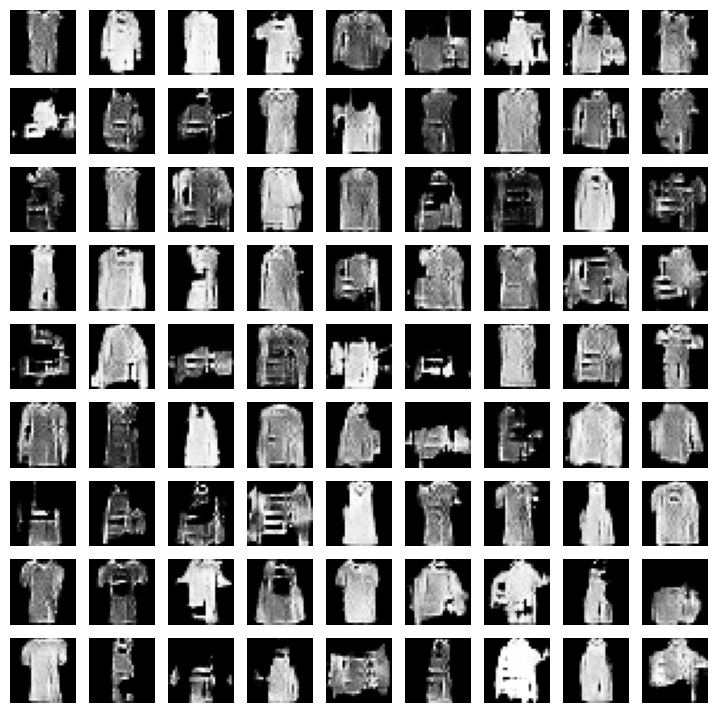

In [53]:
# Geração de imagens com o modelo treinado
images = generator(np.random.normal(size=(81, 150)))
# mostra as imagens geradas
plt.figure(figsize=(9, 9))
for i, image in enumerate(images):
    plt.subplot(9,9,i+1)
    plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
    plt.axis('off')
plt.show();